In [26]:
import pandas as pd
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot  as plt
import numpy as np
import pmdarima as pm
from pmdarima.arima import ARIMA
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import datetime
import requests
import warnings
import matplotlib
import matplotlib.dates as mdates

df = pd.read_csv('multivariate_eng_df.csv', index_col = 'Date', parse_dates = True)
df.head()

,Unnamed: 0,STATE,PROVINCE_STATE_NAME,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,3160,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-02,3161,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-03,3162,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-04,3163,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-05,3164,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [14]:
#questions:
#include new deaths?
#are all models trained on individual state datasets?
#are each individual state datasets, stationary?, seasonal?

In [27]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']

In [28]:
print (df.columns.tolist())

['Unnamed: 0', 'STATE', 'PROVINCE_STATE_NAME', 'Completeness_pct', 'Administered_Dose1_Recip', 'Administered_Dose1_Recip_5Plus', 'Administered_Dose1_Recip_12Plus', 'Administered_Dose1_Recip_18Plus', 'Administered_Dose1_Recip_65Plus', 'Series_Complete_Yes', 'Series_Complete_5Plus', 'Series_Complete_5to17', 'Series_Complete_12Plus', 'Series_Complete_18Plus', 'Series_Complete_65Plus', 'Booster_Doses', 'Booster_Doses_5Plus', 'Booster_Doses_12Plus', 'Booster_Doses_18Plus', 'Booster_Doses_50Plus', 'Booster_Doses_65Plus', 'Second_Booster_50Plus', 'Second_Booster_65Plus', 'Bivalent_Booster_5Plus', 'Bivalent_Booster_12Plus', 'Bivalent_Booster_18Plus', 'Bivalent_Booster_65Plus', 'PEOPLE_DEATH_NEW_COUNT', 'PEOPLE_POSITIVE_NEW_CASES_COUNT', 'TOT_POP', 'WA_MALE', 'WA_FEMALE', 'BA_MALE', 'BA_FEMALE', 'IA_MALE', 'IA_FEMALE', 'AA_MALE', 'AA_FEMALE', 'NA_MALE', 'NA_FEMALE', 'TOM_MALE', 'TOM_FEMALE', 'WAC_MALE', 'WAC_FEMALE', 'BAC_MALE', 'BAC_FEMALE', 'IAC_MALE', 'IAC_FEMALE', 'AAC_MALE', 'AAC_FEMALE', 

In [29]:
#separate univariate dataframe for california
ca_uni_df = ca_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT']]
ca_uni_df.head()

,PEOPLE_POSITIVE_NEW_CASES_COUNT
Date,
2020-03-01,5
2020-03-02,5
2020-03-03,7
2020-03-04,10
2020-03-05,12


In [30]:
#display the largest 10 values
largest_ten = ca_uni_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'].nlargest(10)
print(largest_ten)

Date
2022-01-10    227972
2022-01-17    221235
2022-01-24    215830
2022-01-20    162854
2022-01-13    159736
2022-01-04    141752
2022-01-11    136412
2022-01-21    134562
2022-01-31    124284
2022-01-27    117445
Name: PEOPLE_POSITIVE_NEW_CASES_COUNT, dtype: int64


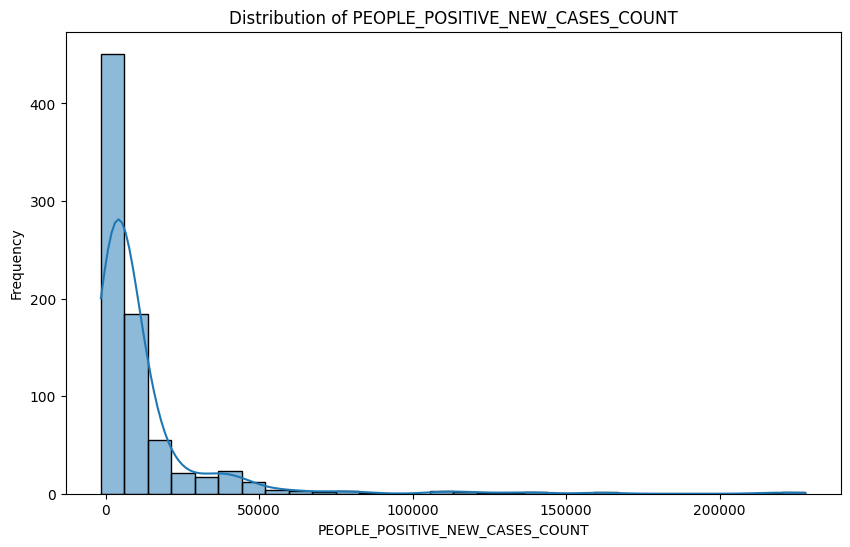

In [31]:
#visualize target distribution
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(ca_uni_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], kde=True, bins=30)
plt.title('Distribution of PEOPLE_POSITIVE_NEW_CASES_COUNT')
plt.xlabel('PEOPLE_POSITIVE_NEW_CASES_COUNT')
plt.ylabel('Frequency')
plt.show()

In [32]:
#separate train & test sets
train_size = int(len(ca_uni_df)* 0.8)
ca_uni_train, ca_uni_test = ca_uni_df[0:train_size], ca_uni_df[train_size:]

In [33]:
ca_uni_test \
    .rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TEST SET'}) \
    .join(ca_uni_train.rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TRAINING SET'}), how='outer')

,TEST SET,TRAINING SET
Date,,
2020-03-01,NaN,5.0
2020-03-02,NaN,5.0
2020-03-03,NaN,7.0
2020-03-04,NaN,10.0
2020-03-05,NaN,12.0
...,...,...
2022-04-25,4531.0,NaN
2022-04-26,16180.0,NaN
2022-04-27,1852.0,NaN


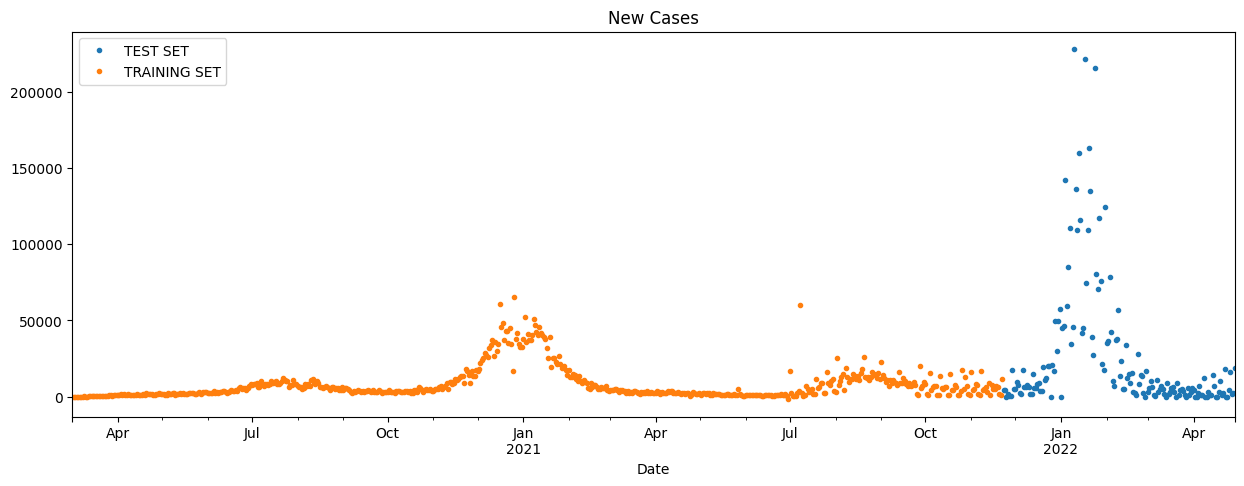

In [34]:
#visualize the 80/20 train/test split
_ = ca_uni_test \
    .rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TEST SET'}) \
    .join(ca_uni_train.rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='New Cases', style='.')

<Axes: xlabel='Date'>

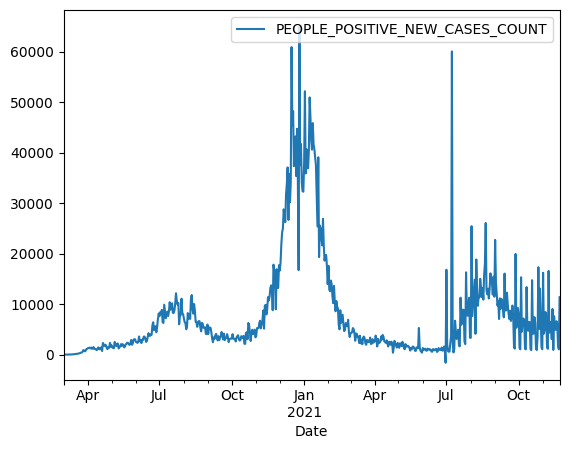

In [35]:
#visualize training dataset
ca_uni_train.plot()

In [36]:
#baseline ARIMA model
from statsmodels.tsa.arima.model import ARIMA
baseline = ARIMA(ca_uni_train, order = (1,1,1))
baseline_model = baseline.fit()
baseline_model.summary()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:     PEOPLE_POSITIVE_NEW_CASES_COUNT   No. Observations:                  632
Model:                              ARIMA(1, 1, 1)   Log Likelihood               -6191.038
Date:                             Fri, 23 Feb 2024   AIC                          12388.077
Time:                                     20:01:47   BIC                          12401.419
Sample:                                 03-01-2020   HQIC                         12393.259
                                      - 11-22-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1087      0.026     -4.154      0.000      -0.160      -0.057
ma.L1         -0.6939      0.021    -33.183      0.000      -0.735      -0.653
sigma2      2.014e+07   2.23e+05     90.235      0.000    1.97e+07    2.06e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             79632.52
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              34.88   Skew:                             4.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
#stationarity tests -- augmented dickey fuller
from statsmodels.tsa.stattools import adfuller
 
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(col):
    result=adfuller(col)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(ca_uni_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'])


ADF Test Statistic : -4.343798863620733
p-value : 0.0003727147926551251
#Lags Used : 19
Number of Observations Used : 770
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [38]:
#identification -- determine values of p & q
#use gridsearch to select values of p and q -- AIC performance metric
warnings.filterwarnings("ignore")

results=[]
for p in range(1,10):
    for q in range(1,10):
        model=ARIMA(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
56,7,3,12309.074467
57,7,4,12310.714079
65,8,3,12310.823929
74,9,3,12311.865118
58,7,5,12312.299663
...,...,...,...
36,5,1,12378.677644
9,2,1,12383.236196
18,3,1,12384.033302
27,4,1,12385.013116


In [39]:
#use gridsearch to select values of p and q -- BIC performance metric
results=[]
for p in range(1,10):
    for q in range(1,10):
        model=ARIMA(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q)).fit()
        results.append([p,q,model.bic])
pd.DataFrame(results, columns=['p','q','bic']).sort_values('bic')

,p,q,bic
46,6,2,12356.108031
56,7,3,12357.994832
47,6,3,12360.797818
55,7,2,12361.163030
63,8,1,12361.309697
...,...,...,...
4,1,5,12406.417650
29,4,3,12407.138327
5,1,6,12407.150263
36,5,1,12409.808785


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

#optimal ARIMA model revealed via gridsearch with AIC for performance evaluation
#train model
opt_arima=ARIMA(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(7,1,3))
opt_arima_fit_1=opt_arima.fit()

#make predictions
predictions_1 = opt_arima_fit_1.predict(start=632,end=789,dynamic=True)

#calculate performance metrics
mae = mean_absolute_error(ca_uni_test, predictions_1)
mse = mean_squared_error(ca_uni_test, predictions_1)
rmse = np.sqrt(mse)
#calculate mape adding a small number to avoid division by zero
predictions_array = np.array(predictions_1)
ca_uni_test_array = np.array(ca_uni_test)
absolute_percent_error = np.where(ca_uni_test_array != 0, np.abs((ca_uni_test_array - predictions_array) / ca_uni_test_array), np.nan)
valid_ape = absolute_percent_error[~np.isnan(absolute_percent_error)]
mape = np.mean(valid_ape) * 100

#naive forecast for mase calculation
naive_forecast = ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = mae / mae_naive

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percent Error: {mape}')
print(f'Mean Absolute Scaled Error: {mase}')

Mean Absolute Error: 23722.379471066903
Root Mean Squared Error: 48866.8621473201
Mean Absolute Percent Error: 4662.084502215349
Mean Absolute Scaled Error: 9.895648841577964


In [43]:
#optimal ARIMA model revealed via gridsearch with BIC for performance evaluation
#train model
opt_arima=ARIMA(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(6,1,2))
opt_arima_fit_2=opt_arima.fit()

#make predictions
predictions_2 = opt_arima_fit_2.predict(start=632,end=789,dynamic=True)

#calculate performance metrics
mae = mean_absolute_error(ca_uni_test, predictions_2)
mse = mean_squared_error(ca_uni_test, predictions_2)
rmse = np.sqrt(mse)

#calculate mape adding a small number to avoid division by zero
predictions_array = np.array(predictions_2)
ca_uni_test_array = np.array(ca_uni_test)
absolute_percent_error = np.where(ca_uni_test_array != 0, np.abs((ca_uni_test_array - predictions_array) / ca_uni_test_array), np.nan)
valid_ape = absolute_percent_error[~np.isnan(absolute_percent_error)]
mape = np.mean(valid_ape) * 100

#naive forecast for mase calculation
naive_forecast = ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = mae / mae_naive

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percent Error: {mape}')
print(f'Mean Absolute Scaled Error: {mase}')

Mean Absolute Error: 23688.72528563637
Root Mean Squared Error: 48794.78119929976
Mean Absolute Percent Error: 4795.833645566305
Mean Absolute Scaled Error: 9.881610199228614


In [44]:
#NEED TO IMPROVE PERFORMANCE 

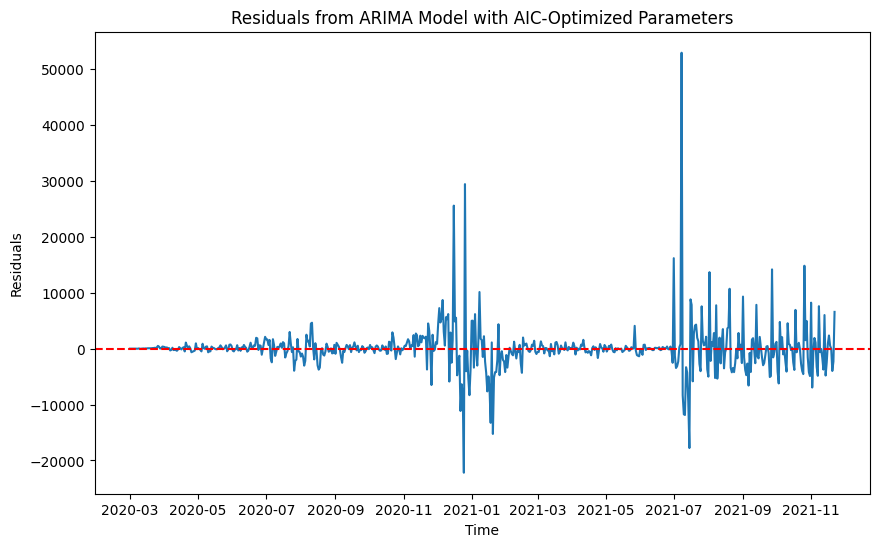

In [45]:
#analyze residuals from the model with parameters optimized using AIC
#extract the residuals
residuals = opt_arima_fit_1.resid

#plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model with AIC-Optimized Parameters')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

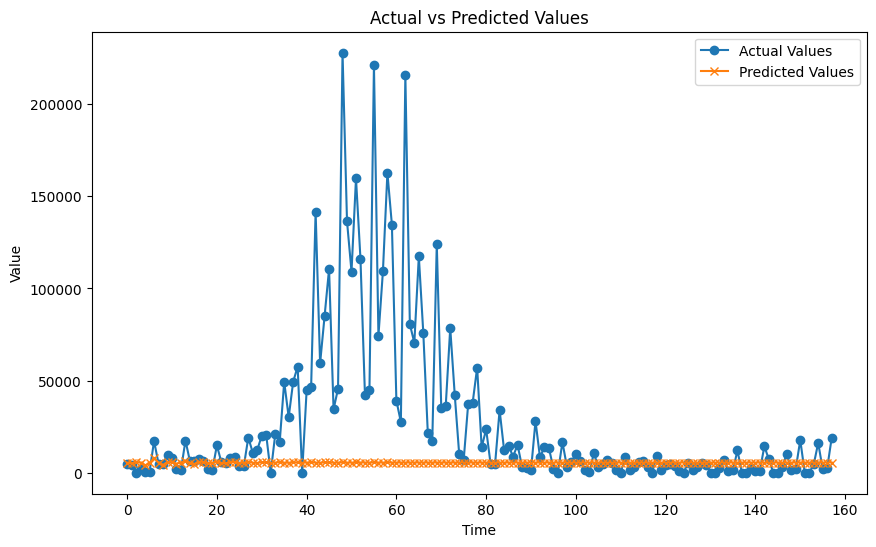

In [46]:
#visualize actual vs predicted values for model with parameters optimized using AIC
ca_uni_test_array = np.array(ca_uni_test)
predictions_array = np.array(predictions_1)

plt.figure(figsize=(10, 6))
plt.plot(ca_uni_test_array, label='Actual Values', marker='o')
plt.plot(predictions_array, label='Predicted Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

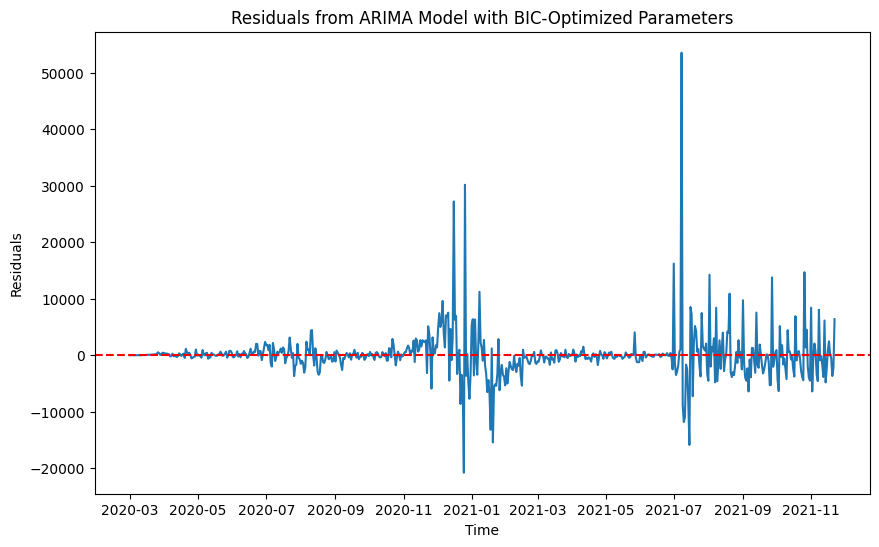

In [47]:
#analyze residuals from the model with parameters optimized using BIC
#extract the residuals
residuals = opt_arima_fit_2.resid

#plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model with BIC-Optimized Parameters')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

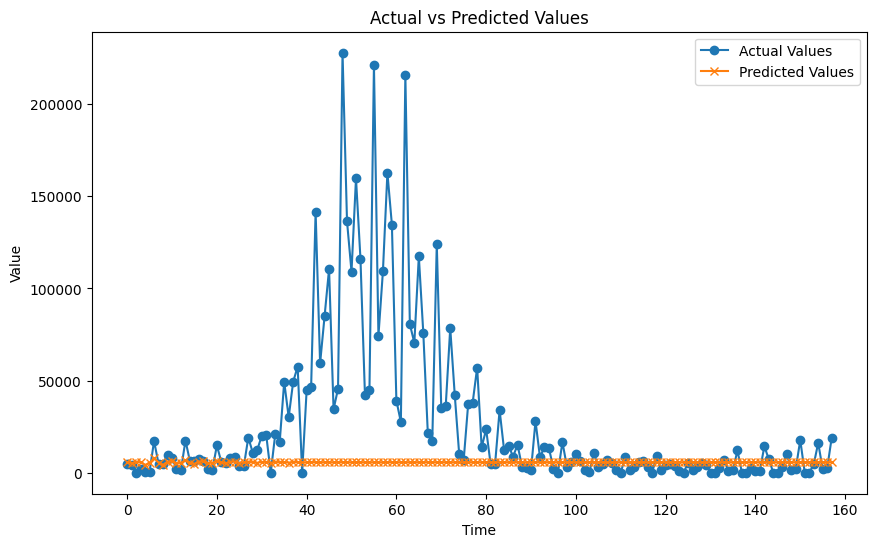

In [48]:
#visualize actual vs predicted values for model with parameters optimized using BIC
ca_uni_test_array = np.array(ca_uni_test)
predictions_array = np.array(predictions_2)

plt.figure(figsize=(10, 6))
plt.plot(ca_uni_test_array, label='Actual Values', marker='o')
plt.plot(predictions_array, label='Predicted Values', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [49]:
print("Predicted Values:")
print(predictions_1)

Predicted Values:
2021-11-23    5446.449122
2021-11-24    5161.669870
2021-11-25    5803.483050
2021-11-26    5426.283584
2021-11-27    4037.881410
                 ...     
2022-04-25    5526.833091
2022-04-26    5526.808824
2022-04-27    5526.821537
2022-04-28    5526.835263
2022-04-29    5526.816963
Freq: D, Name: predicted_mean, Length: 158, dtype: float64


In [50]:
print("Predicted Values:")
print(predictions_2)

Predicted Values:
2021-11-23    5750.486745
2021-11-24    5208.033617
2021-11-25    5871.298611
2021-11-26    5718.281990
2021-11-27    4304.230972
                 ...     
2022-04-25    5689.179321
2022-04-26    5689.090919
2022-04-27    5689.042007
2022-04-28    5689.139679
2022-04-29    5689.141714
Freq: D, Name: predicted_mean, Length: 158, dtype: float64


It looks like we have a bias problem.

In [51]:
#diagnose underfitting/overfitting issues

#fixing high bias -- decrease regularization parameter